# Practical Machine Learning for Physicists
## Week 2 Exercise -- Deadline Monday 26th October at 12pm

This week's exercise is to train some neural networks to mimic functions. The functions that you need to mimic are:
1. A circle  [40 points]
2. A circle with a hole [40 points]
3. A circle with three holes [20 points]

The code below is just a copy and paste of the code from the Week2_NetworkVisualisation notebook. At the bottom of the notebook the three target functions are defined.

For all three exercises marks will be given for the following (equally weighted assuming the network 'succeeeds' in mimic the shape):
- The final cost function (e.g. how well does your network match the target)
- The network simplicity (e.g. matching the target as well with a simpler network is better)
- The network training efficiency (e.g. getting your network trained using as little computing power as possible)
- Notebook readability and code clarity

### Imports: only numpy and matplotlib

In [1]:
#from numpy import array, zeros, exp, random, dot, shape, reshape, meshgrid, linspace
import numpy as np

import matplotlib.pyplot as plt # for plotting
import matplotlib
matplotlib.rcParams['figure.dpi']=300 # highres display

# for subplots within subplots:
from matplotlib import gridspec

# for nice inset colorbars: (approach changed from lecture 1 'Visualization' notebook)
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

# for updating display 
# (very simple animation)
from IPython.display import clear_output
from time import sleep

### Functions

In [2]:
# backpropagation and training routines

# this is basically a merger of the backpropagation
# code shown in lecture 2 and some of the 
# visualization code used in the lecture 1 tutorials!

def net_f_df(z,activation):
    # return both value f(z) and derivative f'(z)
    if activation=='sigmoid':
        return([1/(1+np.exp(-z)), 
                1/((1+np.exp(-z))*(1+np.exp(z))) ])
    elif activation=='jump': # cheating a bit here: replacing f'(z)=delta(z) by something smooth
        return([np.array(z>0,dtype='float'), 
                10.0/((1+np.exp(-10*z))*(1+np.exp(10*z))) ] )
    elif activation=='linear':
        return([z,
                1.0])
    elif activation=='reLU':
        return([(z>0)*z,
                (z>0)*1.0
               ])

def forward_step(y,w,b,activation):
    """
    Go from one layer to the next, given a 
    weight matrix w (shape [n_neurons_in,n_neurons_out])
    a bias vector b (length n_neurons_out)
    and the values of input neurons y_in 
    (shape [batchsize,n_neurons_in])
    
    returns the values of the output neurons in the next layer 
    (shape [batchsize, n_neurons_out])
    """    
    # calculate values in next layer, from input y
    z=np.dot(y,w)+b # w=weights, b=bias vector for next layer
    return(net_f_df(z,activation)) # apply nonlinearity and return result

def apply_net(x_in): # one forward pass through the network
    global Weights, Biases, NumLayers, Activations
    global y_layer, df_layer # for storing y-values and df/dz values
    
    y=np.copy(x_in) # start with input values
    y_layer[0]=np.copy(y)
    for j in range(NumLayers): # loop through all layers
        # j=0 corresponds to the first layer above the input
        y,df=forward_step(y,Weights[j],Biases[j],Activations[j]) # one step
        df_layer[j]=np.copy(df) # store f'(z) [needed later in backprop]
        y_layer[j+1]=np.copy(y) # store f(z) [also needed in backprop]        
    return(y)

def apply_net_simple(x_in): # one forward pass through the network
    # no storage for backprop (this is used for simple tests)
    global Weights, Biases, NumLayers, Activations
    
    y=x_in # start with input values
    for j in range(NumLayers): # loop through all layers
        # j=0 corresponds to the first layer above the input
        y,df=forward_step(y,Weights[j],Biases[j],Activations[j]) # one step
    return(y)

def backward_step(delta,w,df): 
    # delta at layer N, of batchsize x layersize(N))
    # w between N-1 and N [layersize(N-1) x layersize(N) matrix]
    # df = df/dz at layer N-1, of batchsize x layersize(N-1)
    return( np.dot(delta,np.transpose(w))*df )

def backprop(y_target): # one backward pass through the network
    # the result will be the 'dw_layer' matrices that contain
    # the derivatives of the cost function with respect to
    # the corresponding weight
    global y_layer, df_layer, Weights, Biases, NumLayers
    global dw_layer, db_layer # dCost/dw and dCost/db (w,b=weights,biases)

    batchsize=np.shape(y_target)[0]
    delta=(y_layer[-1]-y_target)*df_layer[-1]
    dw_layer[-1]=np.dot(np.transpose(y_layer[-2]),delta)/batchsize
    db_layer[-1]=delta.sum(0)/batchsize
    for j in range(NumLayers-1):
        delta=backward_step(delta,Weights[-1-j],df_layer[-2-j])
        dw_layer[-2-j]=np.dot(np.transpose(y_layer[-3-j]),delta)/batchsize # batchsize was missing in old code?
        db_layer[-2-j]=delta.sum(0)/batchsize
        
def gradient_step(eta): # update weights & biases (after backprop!)
    global dw_layer, db_layer, Weights, Biases
    
    for j in range(NumLayers):
        Weights[j]-=eta*dw_layer[j]
        Biases[j]-=eta*db_layer[j]
        
def train_net(x_in,y_target,eta): # one full training batch
    # x_in is an array of size batchsize x (input-layer-size)
    # y_target is an array of size batchsize x (output-layer-size)
    # eta is the stepsize for the gradient descent
    global y_out_result
    
    y_out_result=apply_net(x_in)
    backprop(y_target)
    gradient_step(eta)
    cost=0.5*((y_target-y_out_result)**2).sum()/np.shape(x_in)[0]
    return(cost)

def init_layer_variables(weights,biases,activations):
    global Weights, Biases, NumLayers, Activations
    global LayerSizes, y_layer, df_layer, dw_layer, db_layer

    Weights=weights
    Biases=biases
    Activations=activations
    NumLayers=len(Weights)

    LayerSizes=[2]
    for j in range(NumLayers):
        LayerSizes.append(len(Biases[j]))

    y_layer=[[] for j in range(NumLayers+1)]
    df_layer=[[] for j in range(NumLayers)]
    dw_layer=[np.zeros([LayerSizes[j],LayerSizes[j+1]]) for j in range(NumLayers)]
    db_layer=[np.zeros(LayerSizes[j+1]) for j in range(NumLayers)]


In [3]:
# visualization routines:

# some internal routines for plotting the network:
def plot_connection_line(ax,X,Y,W,vmax=1.0,linewidth=3):
    t=np.linspace(0,1,20)
    if W>0:   #Pick colour of line based on if weight is positive or negative
        col=[0,0.4,0.8]  
    else:
        col=[1,0.3,0]
    ax.plot(X[0]+(3*t**2-2*t**3)*(X[1]-X[0]),Y[0]+t*(Y[1]-Y[0]),
           alpha=abs(W)/vmax,color=col,
           linewidth=linewidth)
    
def plot_neuron_alpha(ax,X,Y,B,size=100.0,vmax=1.0):
    if B>0: #Pick colour of neuron dot based on if bias is positive or negative
        col=[0,0.4,0.8]
    else:
        col=[1,0.3,0]
    ax.scatter([X],[Y],marker='o',c=np.atleast_2d([col]),alpha=abs(B)/vmax,s=size,zorder=10)

def plot_neuron(ax,X,Y,B,size=100.0,vmax=1.0):
    if B>0:
        col=[0,0.4,0.8]
    else:
        col=[1,0.3,0]
    ax.scatter([X],[Y],marker='o',c=np.atleast_2d([col]),s=size,zorder=10)
    
def visualize_network(weights,biases,activations,
                      M=100,x0range=[-1,1],x1range=[-1,1],
                     size=400.0, linewidth=5.0,
                     weights_are_swapped=False,
                    layers_already_initialized=False,
                      plot_cost_function=None,
                      current_cost=None, cost_max=None, plot_target=None
                     ):
    """
    Visualize a neural network with 2 input 
    neurons and 1 output neuron (plot output vs input in a 2D plot)
    
    weights is a list of the weight matrices for the
    layers, where weights[j] is the matrix for the connections
    from layer j to layer j+1 (where j==0 is the input)
    
    weights[j][m,k] is the weight for input neuron k going to output neuron m
    (note: internally, m and k are swapped, see the explanation of
    batch processing in lecture 2)
    
    biases[j] is the vector of bias values for obtaining the neurons in layer j+1
    biases[j][k] is the bias for neuron k in layer j+1
    
    activations is a list of the activation functions for
    the different layers: choose 'linear','sigmoid',
    'jump' (i.e. step-function), and 'reLU'
    
    M is the resolution (MxM grid)
    
    x0range is the range of x0 neuron values (horizontal axis)
    x1range is the range of x1 neuron values (vertical axis)
    """
    if not weights_are_swapped:
        swapped_weights=[]
        for j in range(len(weights)):
            swapped_weights.append(np.transpose(weights[j]))
    else:
        swapped_weights=weights

    x0,x1=np.meshgrid(np.linspace(x0range[0],x0range[1],M),np.linspace(x1range[0],x1range[1],M))
    x_in=np.zeros([M*M,2])
    x_in[:,0]=x0.flatten()
    x_in[:,1]=x1.flatten()
    
    # if we call visualization directly, we still
    # need to initialize the 'Weights' and other
    # global variables; otherwise (during training)
    # all of this has already been taken care of:
    if not layers_already_initialized:
        init_layer_variables(swapped_weights,biases,activations)
    y_out=apply_net_simple(x_in)

    if plot_cost_function is None:
        fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(8,4))
    else:
        fig=plt.figure(figsize=(8,4))
        gs_top = gridspec.GridSpec(nrows=1, ncols=2)
        gs_left = gridspec.GridSpecFromSubplotSpec(nrows=2, ncols=1, subplot_spec=gs_top[0], height_ratios=[1.0,0.3])
        ax=[ fig.add_subplot(gs_left[0]),
            fig.add_subplot(gs_top[1]),
           fig.add_subplot(gs_left[1]) ]
        # ax[0] is network
        # ax[1] is image produced by network
        # ax[2] is cost function subplot
        
    # plot the network itself:
    
    # positions of neurons on plot:
    posX=[[-0.5,+0.5]]; posY=[[0,0]]
    vmax=0.0 # for finding the maximum weight
    vmaxB=0.0 # for maximum bias
    for j in range(len(biases)):
        n_neurons=len(biases[j])
        posX.append(np.array(range(n_neurons))-0.5*(n_neurons-1))
        posY.append(np.full(n_neurons,j+1))
        vmax=np.maximum(vmax,np.max(np.abs(weights[j])))
        vmaxB=np.maximum(vmaxB,np.max(np.abs(biases[j])))

    # plot connections
    for j in range(len(biases)):
        for k in range(len(posX[j])):
            for m in range(len(posX[j+1])):
                plot_connection_line(ax[0],[posX[j][k],posX[j+1][m]],
                                     [posY[j][k],posY[j+1][m]],
                                     swapped_weights[j][k,m],vmax=vmax,
                                    linewidth=linewidth)
    
    # plot neurons
    for k in range(len(posX[0])): # input neurons (have no bias!)
        plot_neuron(ax[0],posX[0][k],posY[0][k],
                   vmaxB,vmax=vmaxB,size=size)
    for j in range(len(biases)): # all other neurons
        for k in range(len(posX[j+1])):
            plot_neuron(ax[0],posX[j+1][k],posY[j+1][k],
                       biases[j][k],vmax=vmaxB,size=size)
    
    ax[0].axis('off')
    
    # now: the output of the network
    img=ax[1].imshow(np.reshape(y_out,[M,M]),origin='lower',
                    extent=[x0range[0],x0range[1],x1range[0],x1range[1]])
    ax[1].set_xlabel(r'$x_0$')
    ax[1].set_ylabel(r'$x_1$')
    
#     axins1 = inset_axes(ax[1],
#                     width="40%",  # width = 50% of parent_bbox width
#                     height="5%",  # height : 5%
#                     loc='upper right',
#                        bbox_to_anchor=[0.3,0.4])

#    axins1 = ax[1].inset_axes([0.5,0.8,0.45,0.1])
    axins1 = plt.axes([0, 0, 1, 1])
    ip = InsetPosition(ax[1], [0.25, 0.1, 0.5, 0.05])
    axins1.set_axes_locator(ip)

    imgmin=np.min(y_out)
    imgmax=np.max(y_out)
    color_bar=fig.colorbar(img, cax=axins1, orientation="horizontal",ticks=np.linspace(imgmin,imgmax,3))
    cbxtick_obj = plt.getp(color_bar.ax.axes, 'xticklabels')
    plt.setp(cbxtick_obj, color="white")
    axins1.xaxis.set_ticks_position("bottom")

    if plot_target is not None:
        axins2 = plt.axes([0.01, 0.01, 0.99, 0.99])
        ip = InsetPosition(ax[1], [0.75, 0.75, 0.2, 0.2])
        axins2.set_axes_locator(ip)
        axins2.imshow(plot_target,origin='lower')
        axins2.get_xaxis().set_ticks([])
        axins2.get_yaxis().set_ticks([])
        
    if plot_cost_function is not None:
        ax[2].plot(plot_cost_function)
        ax[2].set_ylim([0.0,cost_max])
        ax[2].set_yticks([0.0,cost_max])
        ax[2].set_yticklabels(["0",'{:1.2e}'.format(cost_max)])
        if current_cost is not None:
            ax[2].text(0.9, 0.9, 'cost={:1.2e}'.format(current_cost), horizontalalignment='right',
                       verticalalignment='top', transform=ax[2].transAxes)
    
    plt.show()
    
def visualize_network_training(weights,biases,activations,
                               target_function,
                               num_neurons=None,
                               weight_scale=1.0,
                               bias_scale=1.0,
                               xspread=1.0,
                      M=100,x0range=[-1,1],x1range=[-1,1],
                     size=400.0, linewidth=5.0,
                    steps=100, batchsize=10, eta=0.1,
                              random_init=False,
                              visualize_nsteps=1,
                              plot_target=True):
    """
    Visualize the training of a neural network.
    
    weights, biases, and activations define the neural network 
    (the starting point of the optimization; for the detailed description,
    see the help for visualize_network)
    
    If you want to have layers randomly initialized, just provide
    the number of neurons for each layer as 'num_neurons'. This should include
    all layers, including input (2 neurons) and output (1), so num_neurons=[2,3,5,4,1] is
    a valid example. In this case, weight_scale and bias_scale define the
    spread of the random Gaussian variables used to initialize all weights and biases.
    
    target_function is the name of the function that we
    want to approximate; it must be possible to 
    evaluate this function on a batch of samples, by
    calling target_function(y) on an array y of 
    shape [batchsize,2], where
    the second index refers to the two coordinates
    (input neuron values) x0 and x1. The return
    value must be an array with one index, corresponding
    to the batchsize. A valid example is:
    
    def my_target(y):
        return( np.sin(y[:,0]) + np.cos(y[:,1]) )
    
    steps is the number of training steps
    
    batchsize is the number of samples per training step
    
    eta is the learning rate (stepsize in the gradient descent)
    
    xspread denotes the spread of the Gaussian
    used to sample points in (x0,x1)-space
    
    visualize_n_steps>1 means skip some steps before
    visualizing again (can speed up things)
    
    plot_target=True means do plot the target function in a corner
    
    For all the other parameters, see the help for
        visualize_network
    
    weights and biases as given here will be used
    as starting points, unless you specify
    random_init=True, in which case they will be
    used to determine the spread of Gaussian random
    variables used for initialization!
    """
    
    if num_neurons is not None: # build weight matrices as randomly initialized
        weights=[weight_scale*np.random.randn(num_neurons[j+1],num_neurons[j]) for j in range(len(num_neurons)-1)]
        biases=[bias_scale*np.random.randn(num_neurons[j+1]) for j in range(len(num_neurons)-1)]
    
    swapped_weights=[]
    for j in range(len(weights)):
        swapped_weights.append(np.transpose(weights[j]))
    init_layer_variables(swapped_weights,biases,activations)
    
    if plot_target:
        x0,x1=np.meshgrid(np.linspace(x0range[0],x0range[1],M),np.linspace(x1range[0],x1range[1],M))
        y=np.zeros([M*M,2])
        y[:,0]=x0.flatten()
        y[:,1]=x1.flatten()
        plot_target_values=np.reshape(target_function(y),[M,M])
    else:
        plot_target_values=None
    
    y_target=np.zeros([batchsize,1])
    costs=np.zeros(steps)
    
    for j in range(steps):
        # produce samples (random points in x0,x1-space):
        x_in=xspread*np.random.randn(batchsize,2)
        # apply target function to those points:
        y_target[:,0]=target_function(x_in)
        # do one training step on this batch of samples:
        costs[j]=train_net(x_in,y_target,eta)
        
        # now visualize the updated network:
        if j%visualize_nsteps==0:
            clear_output(wait=True) # for animation
            if j>10:
                cost_max=np.average(costs[0:j])*1.5
            else:
                cost_max=costs[0]
            visualize_network(Weights,Biases,activations,
                          M,x0range=x0range,x1range=x1range,
                         size=size, linewidth=linewidth,
                             weights_are_swapped=True,
                             layers_already_initialized=True,
                             plot_cost_function=costs,
                             current_cost=costs[j],
                             cost_max=cost_max,
                             plot_target=plot_target_values)
            sleep(0.1) # wait a bit before next step (probably not needed)

## Targets

## Circle target  [40 points]
Train a network to mimic the following target (e.g. using the visualize_network_training function above)

In [4]:
def circle_target(x):  #A circle of radius 2 around the origin
    R=2.0
    return( 1.0*( x[:,0]**2+x[:,1]**2<R**2 ) )
import time
import psutil

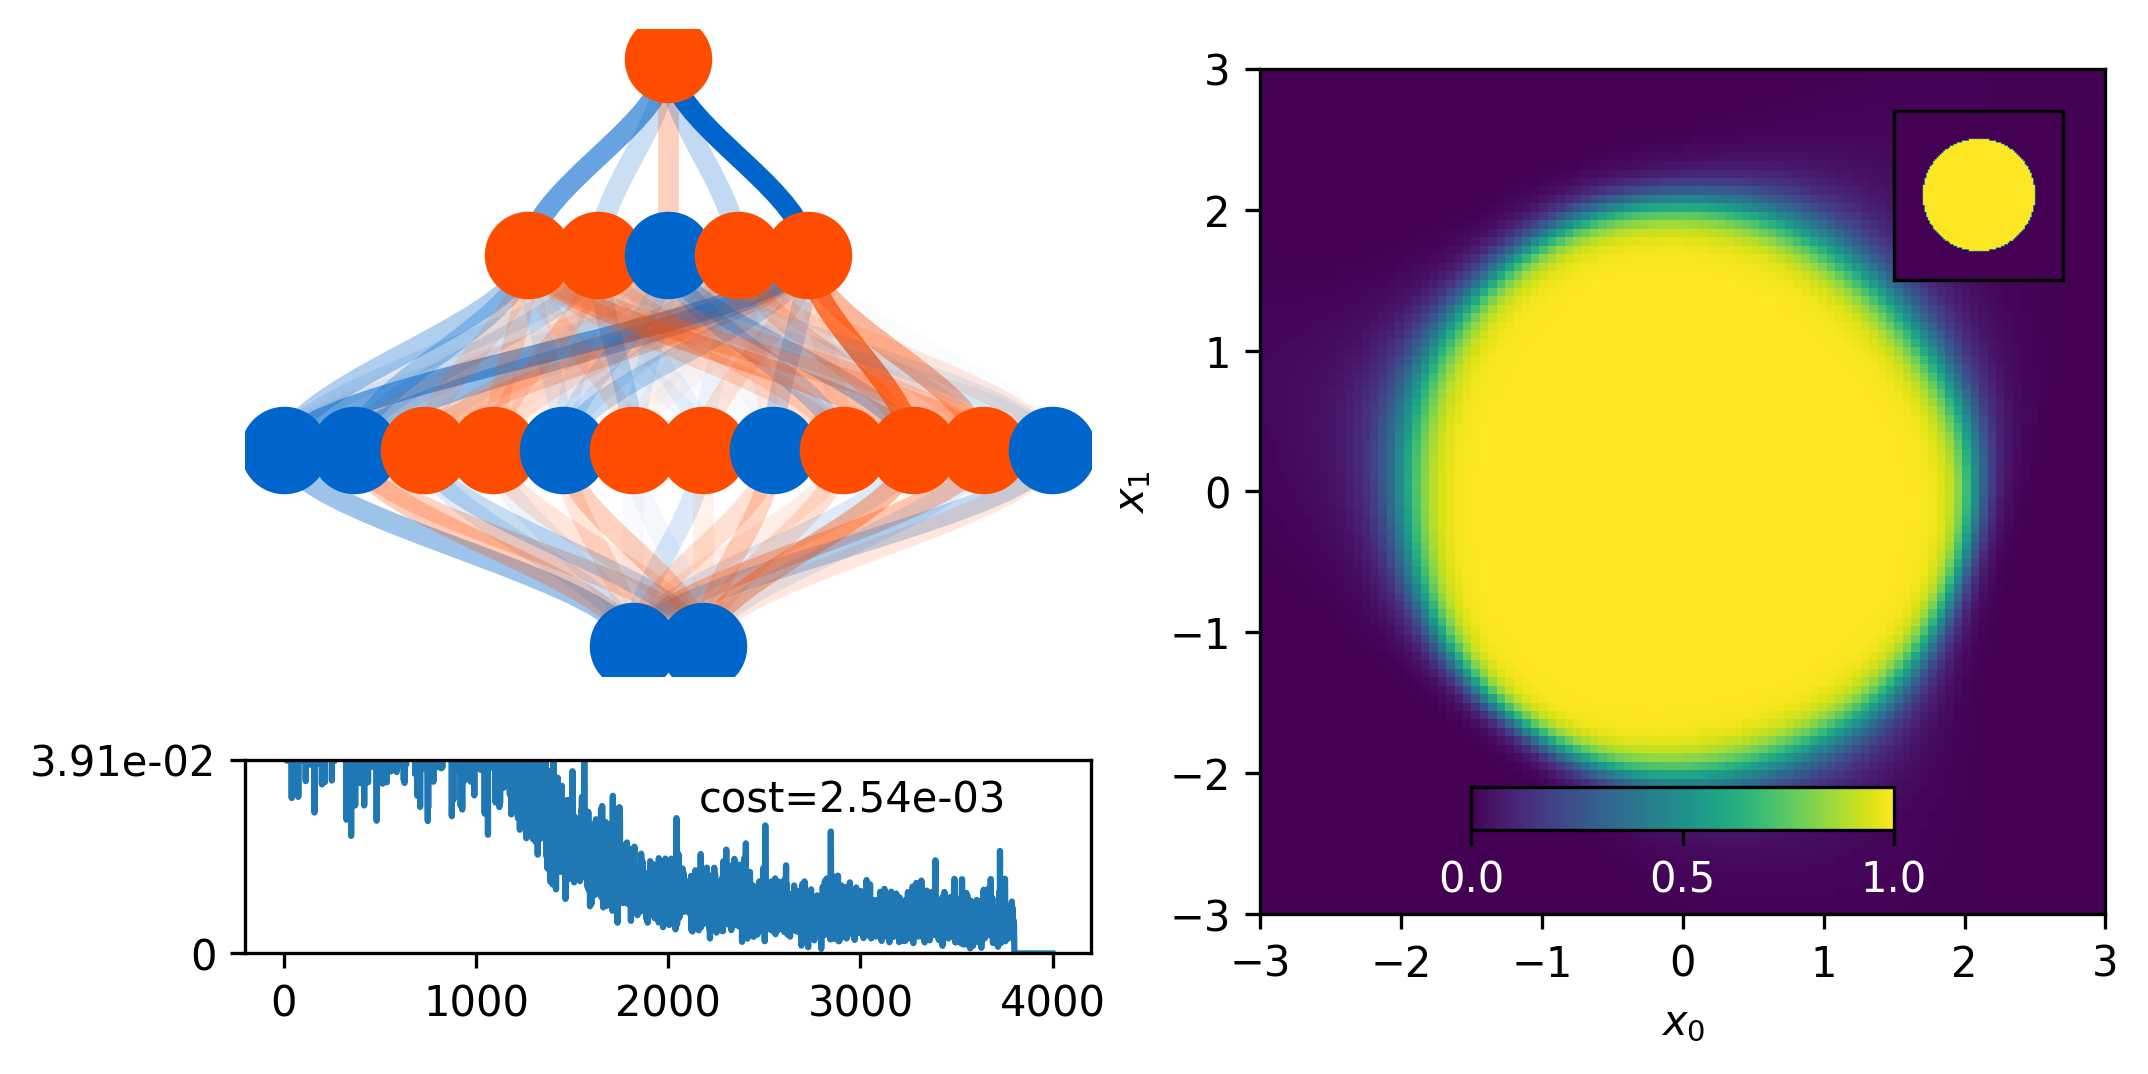

Time taken:  31.596073865890503 s CPU usage is:  31.5


In [91]:
#Not weights or biases
start_time= time.time() #start timer

visualize_network_training(weights=[],biases=[],
    num_neurons=[2,12,5,1],bias_scale=0.001,weight_scale=0.5,#0.5->5.5e-3 cost
    target_function=circle_target, 
    activations=[ 'sigmoid',
                 'linear',
                 'sigmoid'],     #output layer activation   
    x0range=[-3,3],x1range=[-3,3],
    steps=4000, eta=.9, batchsize=100,visualize_nsteps=200, plot_target=True)

end_time=time.time()   #end timer
total_time=end_time-start_time

print('Time taken: ',total_time,'s','CPU usage is: ', psutil.cpu_percent(4))

## Circle hole target [40 points]
Train a network to mimic the following target (e.g. using the visualize_network_training function above)

In [61]:
def circle_hole_target(x):#A circle of radius 2, with a hole of radius 1 around the origin
    r=1.0; R=2.0
    return( 1.0*( x[:,0]**2+x[:,1]**2<R**2 ) - 1.0*( (x[:,0])**2+(x[:,1])**2<r**2))

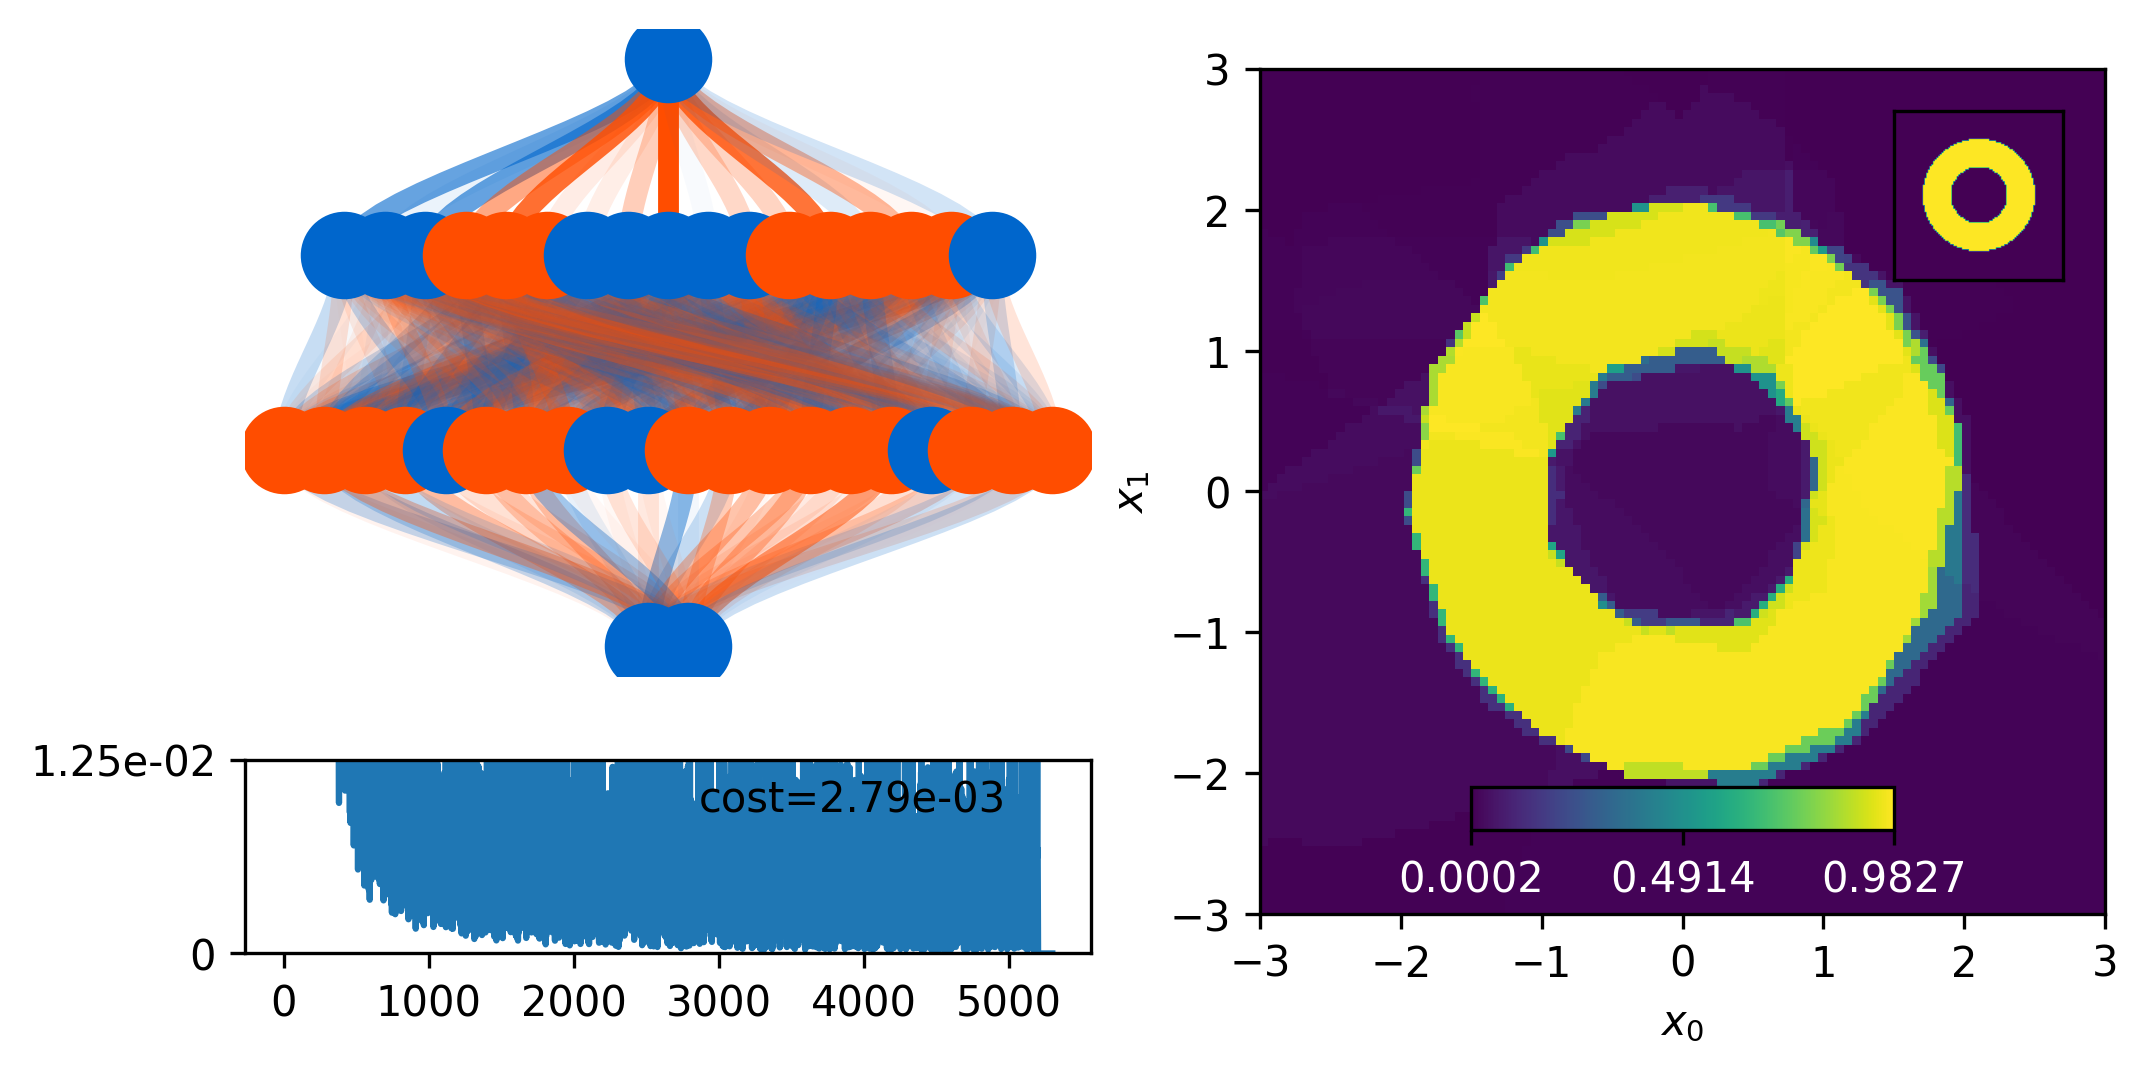

115.39858293533325
CPU usage is:  5.0


In [62]:

start=time.time()    #start timer
    
visualize_network_training(weights=[],biases=[],
    num_neurons=[2,20,17,1], 
    bias_scale=0.001, weight_scale=0.4, 
    target_function=circle_hole_target, 
    activations=['reLU',
                 'jump',
                 'sigmoid'    #output layer activation      
                ],
    x0range=[-3,3],x1range=[-3,3],
    xspread=3,
    steps=5300, eta=1.1, batchsize=150,#1.3 lrate
                          visualize_nsteps=100)

end=time.time()     #end timer  
total_time=end-start
print(total_time)
print('CPU usage is: ', psutil.cpu_percent(4))

## Scream target [20 points]
Train a network to mimic the following target (e.g. using the visualize_network_training function above). Note this target is much more difficult than the previous two.

In [63]:
def scream_target(x): #A circle of radius 2, two eyes of radius 0.5 and a mouth of radius 0.8
    a=0.8; r=0.5; R=2.0; r2=0.8
    return( 1.0*( x[:,0]**2+x[:,1]**2<R**2 ) - 1.0*( (x[:,0]-a)**2+(x[:,1]-a)**2<r**2) - 1.0*( (x[:,0]+a)**2+(x[:,1]-a)**2<r**2 ) - 1.0*( (x[:,0])**2+(x[:,1]+a)**2<r2**2 ) )


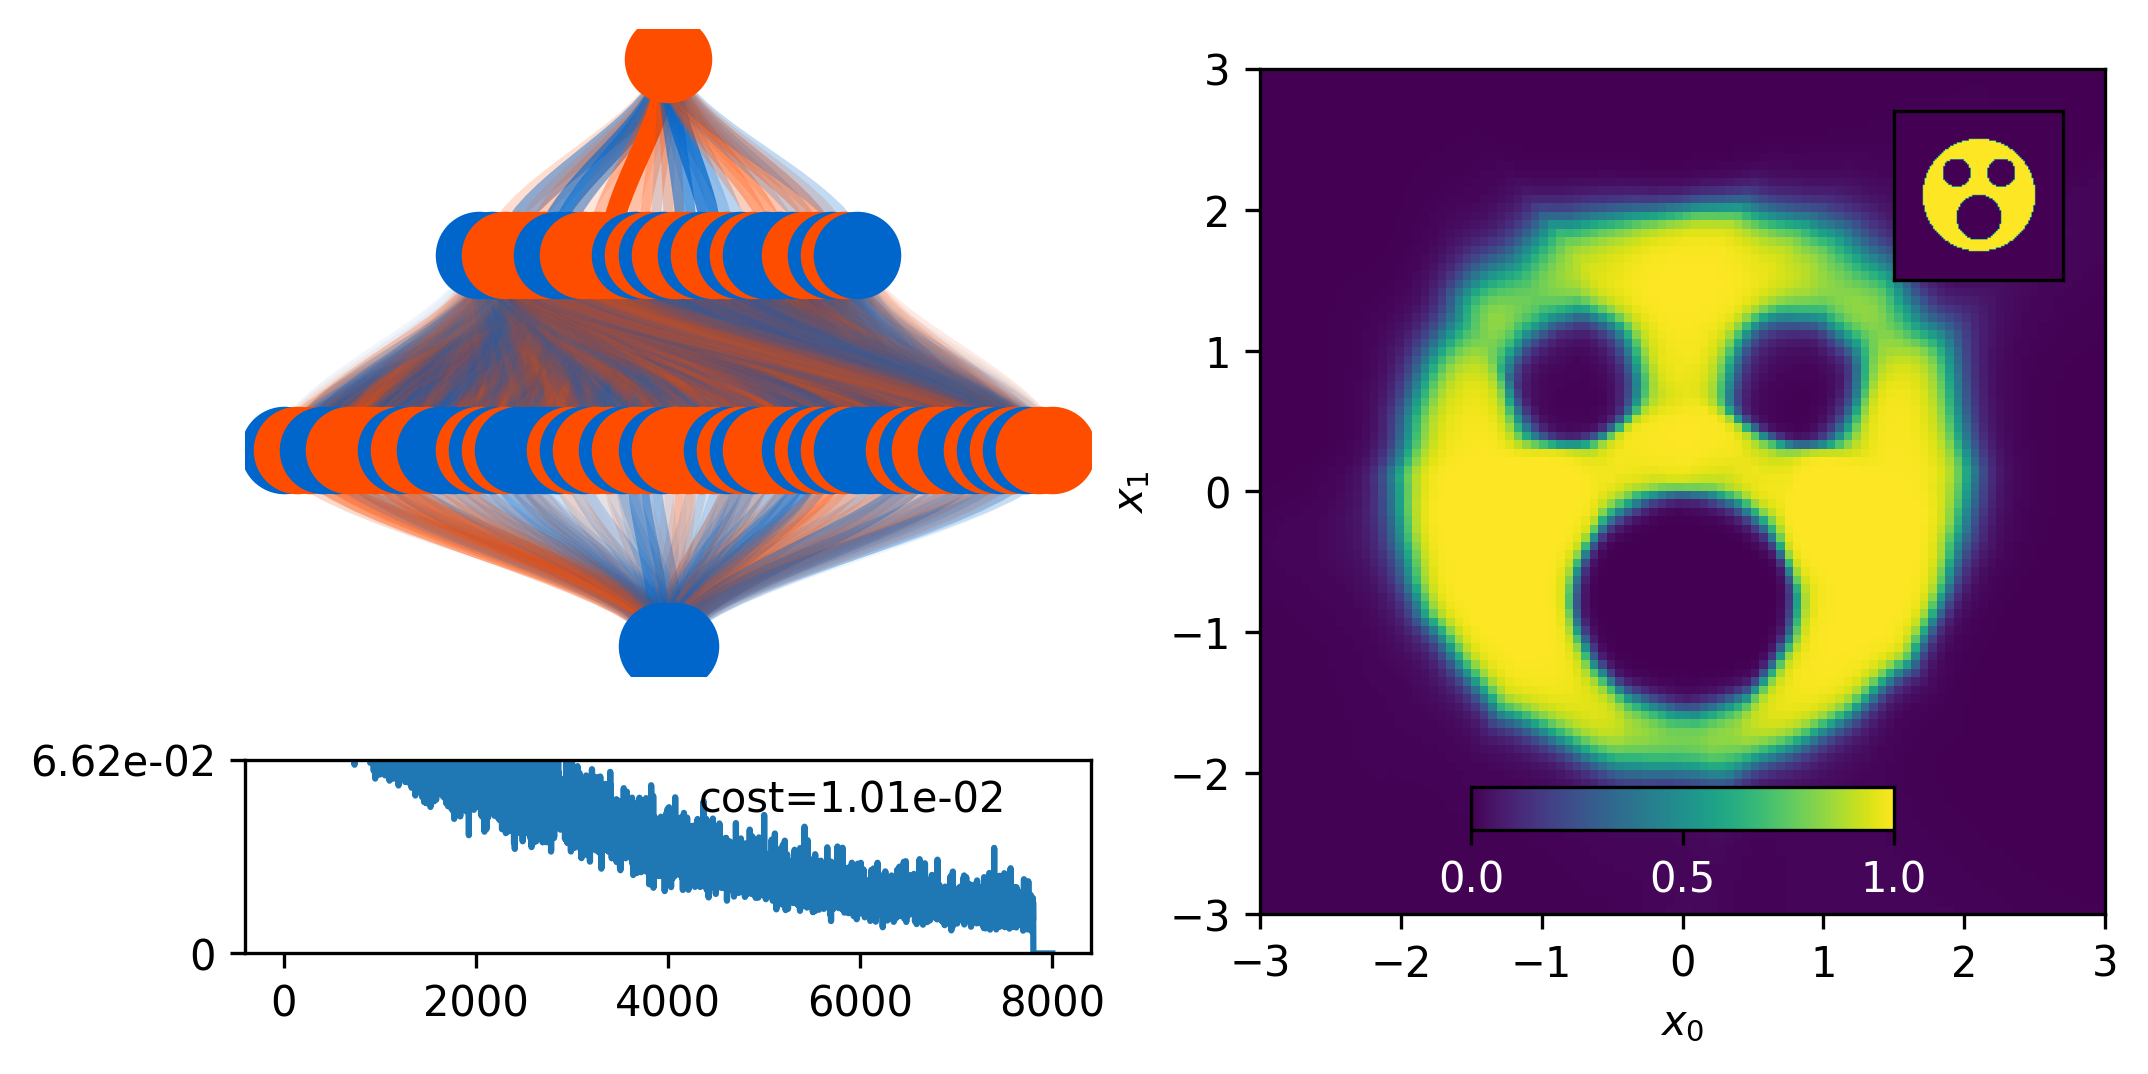

360.6274428367615
CPU usage is:  28.5


In [81]:
#start timer
start=time.time()

visualize_network_training(weights=[],biases=[],
    num_neurons=[2,60,30,1],
    bias_scale=0.01,weight_scale=0.4,
    target_function=scream_target, # the target function to approximate
    activations=[ 'reLU',
                 'sigmoid',
                 'sigmoid'# activation for output
                ],
    x0range=[-3,3],x1range=[-3,3],
    steps=8000, eta=0.7, batchsize=120,
                          visualize_nsteps=200, plot_target=True)

#end timer
end=time.time()
total_time=end-start
print(total_time)
print('CPU usage is: ', psutil.cpu_percent(4))